# P1: Trend Filters on BollingerMeanReversion — BTC/USDT

**Research question (from roadmap P1):**
> Trend filters *hurt* BollingerBreakout because they lag momentum entries.
> Does the same logic *help* BollingerMeanReversion, where the correct
> regime is a ranging/flat market?

**Filter logic (inverted from Breakout):**

| Variant | Logic |
|---|---|
| Unfiltered | trade all signals |
| ADX ranging | only trade when `adx < threshold` (ranging, not trending) |
| Slope flat | only trade when slope is flat (`slope_dir == 0`) |
| Slope aligned | keep long when slope ≥ 0, keep short when slope ≤ 0 |
| ADX + aligned | ADX ranging AND slope-aligned |

**Parts:**
- §1–5: Single-period analysis (Jan–Jun 2024)
- §6–7: Multi-period analysis across 5 distinct market regimes
- §8: Conclusions and implications for roadmap

In [1]:
# ── Configuration ─────────────────────────────────────────────────────────────
SYMBOL = "BTC/USDT"

# Single-period window
SINCE = "2024-01-01"
UNTIL = "2024-06-01"

# Strategy params
BB_PERIOD  = 20
BB_NUM_STD = 2.0

# Signal params
ADX_PERIOD     = 14
ADX_THRESHOLD  = 25.0
MA_PERIOD      = 20
SLOPE_WINDOW   = 5
FLAT_THRESHOLD = 0.05

# Multi-period windows (label → (since, until))
PERIODS = {
    "2023 Q2-Q3\n(bear/ranging)": ("2023-05-01", "2023-09-30"),
    "2024 Q1\n(pre-halving)": ("2024-01-01", "2024-03-31"),
    "2024 Q2\n(bull run)": ("2024-04-01", "2024-06-30"),
    "2024 Q3\n(correction)": ("2024-07-01", "2024-09-30"),
    "2024 Q4\n(bull to 100k)": ("2024-10-01", "2024-12-31"),
}

In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

sys.path.insert(0, str(Path().resolve().parent))

from data.fetch import fetch_ohlcv
from signals.trend.adx import ADXTrend
from signals.trend.ma_slope import MASlopeTrend
from strategies.single.basic.bollinger_bands import BollingerMeanReversion, BollingerBreakout
from backtesting.metrics import compute_metrics

VARIANT_COLORS = {
    "Unfiltered":    "grey",
    "ADX ranging":   "steelblue",
    "Slope flat":    "darkorange",
    "Slope aligned": "mediumorchid",
    "ADX + aligned": "green",
}

pct_rows = {"total_return", "mean_return", "std_return",
            "mean_neg_return", "std_neg_return",
            "return_p05", "return_p25", "return_p75", "return_p95",
            "max_drawdown", "win_rate"}

def fmt(row_name, val):
    if pd.isna(val): return "nan"
    return f"{val*100:.2f}%" if row_name in pct_rows else f"{val:.4f}"

def build_variants(df):
    """Given an OHLCV df, return dict of signal variants."""
    adx_df   = ADXTrend(period=ADX_PERIOD, trend_threshold=ADX_THRESHOLD).compute(df)
    slope_df = MASlopeTrend(ma_period=MA_PERIOD, slope_window=SLOPE_WINDOW,
                            flat_threshold=FLAT_THRESHOLD).compute(df)
    mr_df    = BollingerMeanReversion(period=BB_PERIOD, num_std=BB_NUM_STD).generate_signals(df)
    base     = mr_df["signal"]
    adx_r    = adx_df["adx"] < ADX_THRESHOLD
    slope_d  = slope_df["trend_dir"]
    s_align  = (base == slope_d) | (slope_d == 0)
    return {
        "Unfiltered":    base,
        "ADX ranging":   base.where(adx_r, 0),
        "Slope flat":    base.where(slope_d == 0, 0),
        "Slope aligned": base.where(s_align, 0),
        "ADX + aligned": base.where(adx_r & s_align, 0),
    }, adx_df, slope_df

def build_equity(sig, df):
    mret = df["close"].pct_change().fillna(0)
    return (1 + sig.shift(1).fillna(0) * mret).cumprod()

In [3]:
df = fetch_ohlcv(symbol=SYMBOL, since=SINCE, until=UNTIL)
print(f"Single-period data: {len(df):,} bars  |  {df.index[0]}  →  {df.index[-1]}")

Single-period data: 3,649 bars  |  2024-01-01 00:00:00+00:00  →  2024-06-01 00:00:00+00:00


---
## §1. Build signals and filtered variants

In [4]:
variants, adx_df, slope_df = build_variants(df)

print("Active bars per variant:")
for name, sig in variants.items():
    pct = (sig != 0).mean() * 100
    print(f"  {name:<18} {(sig != 0).sum():>5} bars  ({pct:.1f}%)")

Active bars per variant:
  Unfiltered           421 bars  (11.5%)
  ADX ranging          219 bars  (6.0%)
  Slope flat           190 bars  (5.2%)
  Slope aligned        198 bars  (5.4%)
  ADX + aligned        133 bars  (3.6%)


## §2. Equity curves

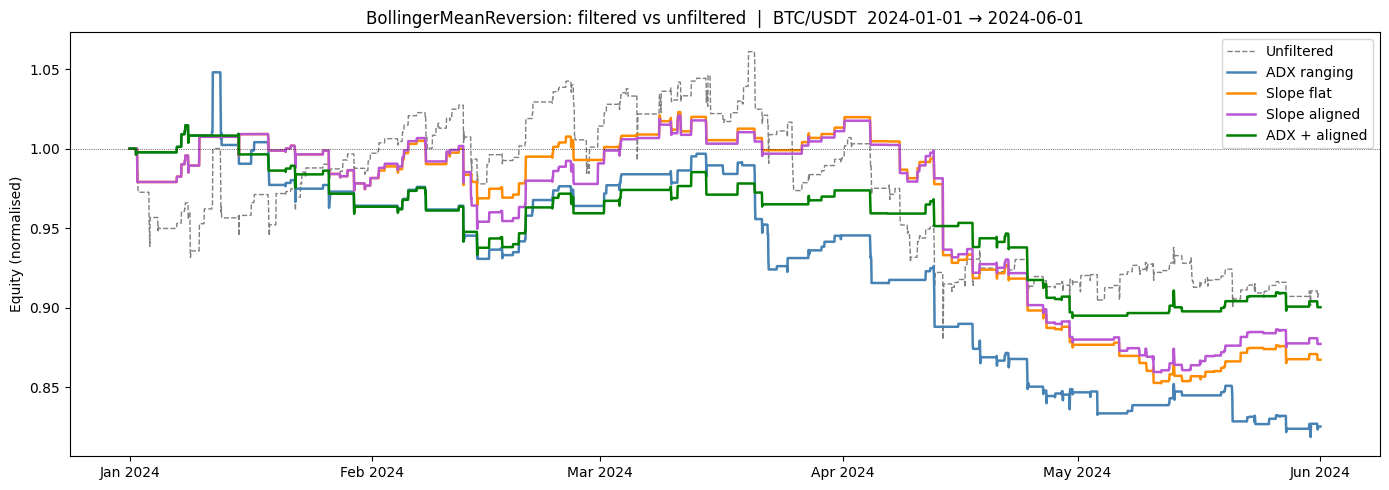

In [5]:
equities = {name: build_equity(sig, df) for name, sig in variants.items()}

fig, ax = plt.subplots(figsize=(14, 5))
for name, equity in equities.items():
    ax.plot(equity.index, equity, label=name, color=VARIANT_COLORS[name],
            lw=1.8 if name != "Unfiltered" else 1.0,
            ls="--" if name == "Unfiltered" else "-")
ax.axhline(1, color="black", lw=0.5, ls=":")
ax.set_title(f"BollingerMeanReversion: filtered vs unfiltered  |  {SYMBOL}  {SINCE} → {UNTIL}")
ax.set_ylabel("Equity (normalised)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.tight_layout()
plt.show()

## §3. Metrics comparison

In [6]:
all_metrics = {name: compute_metrics(eq) for name, eq in equities.items()}
comparison  = pd.DataFrame(all_metrics)
formatted   = comparison.apply(lambda col: [fmt(idx, v) for idx, v in col.items()])
formatted.index = comparison.index
formatted

,Unfiltered,ADX ranging,Slope flat,Slope aligned,ADX + aligned
total_return,-9.14%,-17.47%,-13.27%,-12.28%,-9.97%
mean_return,-0.00%,-0.01%,-0.00%,-0.00%,-0.00%
std_return,0.28%,0.18%,0.16%,0.17%,0.12%
sharpe_ratio,-0.7582,-2.6985,-2.1991,-1.9576,-2.2208
sortino_ratio,-0.3002,-0.8048,-0.5214,-0.4751,-0.5219
mean_neg_return,-0.64%,-0.67%,-0.64%,-0.65%,-0.65%
std_neg_return,0.70%,0.59%,0.68%,0.68%,0.50%
return_p05,-0.01%,0.00%,0.00%,0.00%,0.00%
return_p25,0.00%,0.00%,0.00%,0.00%,0.00%
return_p75,0.00%,0.00%,0.00%,0.00%,0.00%


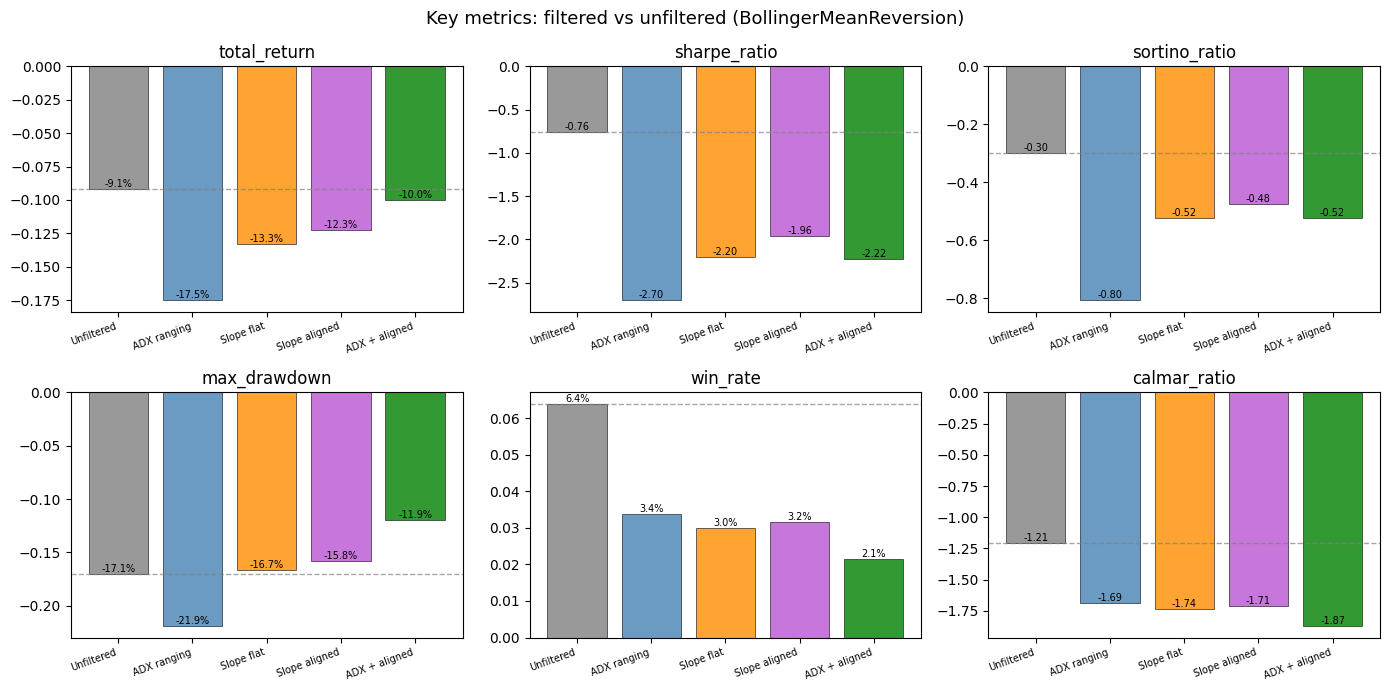

In [7]:
key_metrics = ["total_return", "sharpe_ratio", "sortino_ratio",
               "max_drawdown", "win_rate", "calmar_ratio"]
labels     = list(variants.keys())

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
fig.suptitle("Key metrics: filtered vs unfiltered (BollingerMeanReversion)", fontsize=13)

for ax, metric in zip(axes.flat, key_metrics):
    vals = [all_metrics[l][metric] for l in labels]
    bars = ax.bar(labels, vals, color=[VARIANT_COLORS[l] for l in labels],
                  alpha=0.8, edgecolor="black", lw=0.5)
    ax.axhline(0, color="black", lw=0.5)
    ax.axhline(all_metrics["Unfiltered"][metric], color="grey", lw=1, ls="--", alpha=0.7)
    ax.set_title(metric)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=20, ha="right", fontsize=7)
    for bar, val in zip(bars, vals):
        if not np.isnan(val):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f"{val*100:.1f}%" if metric in pct_rows else f"{val:.2f}",
                    ha="center", va="bottom", fontsize=7)
plt.tight_layout()
plt.show()

## §4. Regime sit-out visualisation

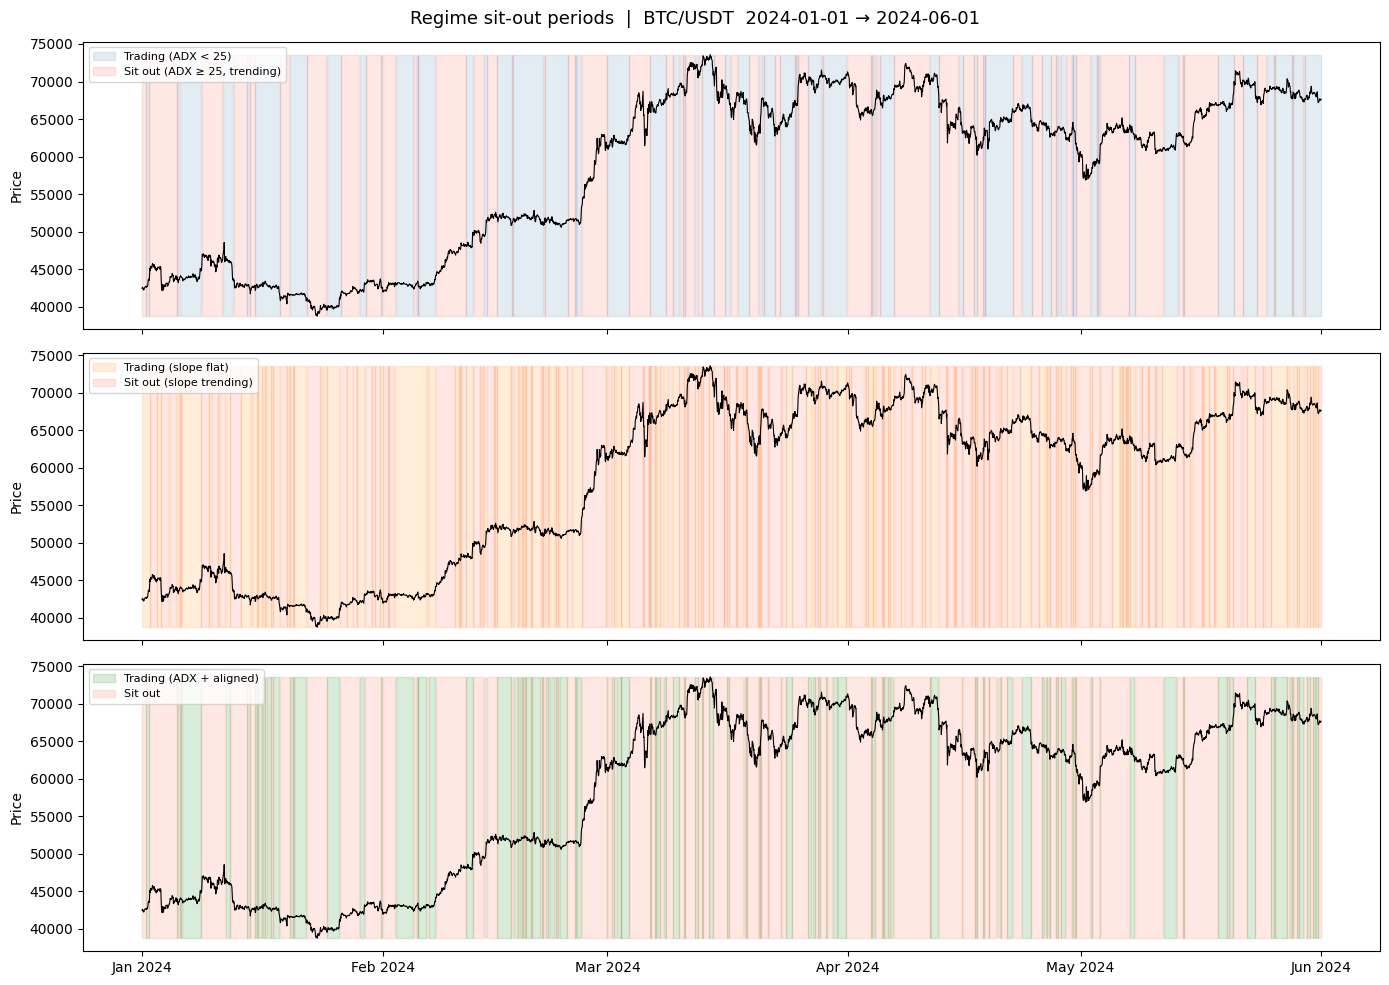

In [8]:
adx_ranging   = adx_df["adx"] < ADX_THRESHOLD
slope_dir     = slope_df["trend_dir"]
base_sig      = variants["Unfiltered"]
slope_aligned = (base_sig == slope_dir) | (slope_dir == 0)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle(f"Regime sit-out periods  |  {SYMBOL}  {SINCE} → {UNTIL}", fontsize=13)
price = df["close"]
lo, hi = price.min(), price.max()

for ax, mask, active_label, inactive_label, color in [
    (axes[0], adx_ranging,
     "Trading (ADX < 25)", "Sit out (ADX ≥ 25, trending)", "steelblue"),
    (axes[1], slope_dir == 0,
     "Trading (slope flat)", "Sit out (slope trending)", "darkorange"),
    (axes[2], adx_ranging & slope_aligned,
     "Trading (ADX + aligned)", "Sit out", "green"),
]:
    ax.plot(price.index, price, lw=0.8, color="black")
    ax.fill_between(price.index, lo, hi, where=mask,  alpha=0.15, color=color,  label=active_label)
    ax.fill_between(price.index, lo, hi, where=~mask, alpha=0.15, color="tomato", label=inactive_label)
    ax.set_ylabel("Price")
    ax.legend(loc="upper left", fontsize=8)

axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.tight_layout()
plt.show()

## §5. Single-period delta summary

In [9]:
base = all_metrics["Unfiltered"]
rows = []
for name in ["ADX ranging", "Slope flat", "Slope aligned", "ADX + aligned"]:
    m = all_metrics[name]
    rows.append({
        "variant":       name,
        "total_return":  f"{m['total_return']*100:.2f}%",
        "Δ return":      f"{(m['total_return']-base['total_return'])*100:+.2f}pp",
        "sharpe":        f"{m['sharpe_ratio']:.3f}",
        "Δ sharpe":      f"{m['sharpe_ratio']-base['sharpe_ratio']:+.3f}",
        "max_drawdown":  f"{m['max_drawdown']*100:.2f}%",
        "Δ drawdown":    f"{(m['max_drawdown']-base['max_drawdown'])*100:+.2f}pp",
        "coverage":      f"{(variants[name] != 0).mean()*100:.1f}%",
    })
display(pd.DataFrame(rows).set_index("variant"))

,total_return,Δ return,sharpe,Δ sharpe,max_drawdown,Δ drawdown,coverage
variant,,,,,,,
ADX ranging,-17.47%,-8.33pp,-2.698,-1.940,-21.87%,-4.82pp,6.0%
Slope flat,-13.27%,-4.13pp,-2.199,-1.441,-16.66%,+0.39pp,5.2%
Slope aligned,-12.28%,-3.14pp,-1.958,-1.199,-15.81%,+1.25pp,5.4%
ADX + aligned,-9.97%,-0.83pp,-2.221,-1.463,-11.92%,+5.13pp,3.6%


---
## §6. Multi-period market regime characterisation

One period is not enough to evaluate a strategy. We test across 5 windows
spanning bear, ranging, and bull regimes to understand regime-dependence.

| Period | Expected character |
|---|---|
| 2023 Q2–Q3 | Bear/ranging market, low vol |
| 2024 Q1 | Pre-halving drift, mild bull |
| 2024 Q2 | Post-halving strong bull run |
| 2024 Q3 | Post-ATH correction |
| 2024 Q4 | Second bull run to 100k |

In [10]:
# ── Fetch all periods and characterise market regimes ─────────────────────────
period_data = {}
regime_rows = []

for label, (since, until) in PERIODS.items():
    pdf = fetch_ohlcv(symbol=SYMBOL, since=since, until=until)
    short_label = label.replace("\n", " ")

    if len(pdf) < 2:
        print(f"  {short_label:<30}  ⚠ no data returned — skipping")
        continue

    period_data[label] = pdf
    mret      = pdf["close"].pct_change().dropna()
    total_ret = pdf["close"].iloc[-1] / pdf["close"].iloc[0] - 1
    adx_vals  = ADXTrend(period=ADX_PERIOD, trend_threshold=ADX_THRESHOLD).compute(pdf)["adx"].dropna()
    regime_rows.append({
        "period":        short_label,
        "bars":          len(pdf),
        "mkt_return":    f"{total_ret*100:.1f}%",
        "annl_vol":      f"{mret.std() * np.sqrt(8760)*100:.1f}%",
        "avg_adx":       f"{adx_vals.mean():.1f}",
        "pct_trending":  f"{(adx_vals >= ADX_THRESHOLD).mean()*100:.1f}%",
        "pct_bull_bars": f"{(mret > 0).mean()*100:.1f}%",
        "regime":        ("BULL" if total_ret > 0.15 else
                          "BEAR" if total_ret < -0.05 else "RANGING"),
    })
    print(f"  {short_label:<30}  {len(pdf):,} bars  mkt={total_ret*100:+.1f}%")

regime_df = pd.DataFrame(regime_rows).set_index("period")
print()
display(regime_df)

  2023 Q2-Q3 (bear/ranging)       ⚠ no data returned — skipping
  2024 Q1 (pre-halving)           2,161 bars  mkt=+64.5%
  2024 Q2 (bull run)              2,161 bars  mkt=-14.2%
  2024 Q3 (correction)            2,185 bars  mkt=+4.0%
  2024 Q4 (bull to 100k)          2,185 bars  mkt=+45.6%



,bars,mkt_return,annl_vol,avg_adx,pct_trending,pct_bull_bars,regime
period,,,,,,,
2024 Q1 (pre-halving),2161,64.5%,55.9%,26.7,46.6%,51.9%,BULL
2024 Q2 (bull run),2161,-14.2%,48.4%,27.7,52.2%,50.2%,BEAR
2024 Q3 (correction),2185,4.0%,55.3%,28.7,55.3%,50.2%,RANGING
2024 Q4 (bull to 100k),2185,45.6%,50.9%,27.1,53.3%,52.2%,BULL


## §7. Strategy performance heatmaps across periods

In [11]:
# ── Run all variants on all periods ───────────────────────────────────────────
# Use only periods that were successfully fetched
variant_names = list(VARIANT_COLORS.keys())
period_labels = [l.replace("\n", " ") for l in period_data.keys()]  # only fetched periods

results = {}   # (period_label, variant) → metrics dict

for label, pdf in period_data.items():
    short_label = label.replace("\n", " ")
    pvariants, _, _ = build_variants(pdf)
    for vname, sig in pvariants.items():
        eq = build_equity(sig, pdf)
        results[(short_label, vname)] = compute_metrics(eq)

# ── Build heatmap DataFrames ──────────────────────────────────────────────────
def make_heatmap_df(metric):
    return pd.DataFrame(
        [[results[(p, v)][metric] for v in variant_names] for p in period_labels],
        index=period_labels, columns=variant_names
    )

sharpe_df  = make_heatmap_df("sharpe_ratio")
return_df  = make_heatmap_df("total_return")
dd_df      = make_heatmap_df("max_drawdown")

print(f"Periods included: {period_labels}")
print("\nSharpe ratio by period × variant:")
display(sharpe_df.style.format("{:.2f}").background_gradient(cmap="RdYlGn", vmin=-3, vmax=3))

Periods included: ['2024 Q1 (pre-halving)', '2024 Q2 (bull run)', '2024 Q3 (correction)', '2024 Q4 (bull to 100k)']

Sharpe ratio by period × variant:


,Unfiltered,ADX ranging,Slope flat,Slope aligned,ADX + aligned
2024 Q1 (pre-halving),0.03,-1.25,0.45,0.38,-0.86
2024 Q2 (bull run),-1.35,-3.90,-3.75,-3.37,-2.82
2024 Q3 (correction),-3.83,-2.08,-1.93,-1.95,-1.63
2024 Q4 (bull to 100k),2.21,1.27,3.04,3.24,1.82


In [12]:
print("Total return by period × variant:")
display(return_df.style.format("{:.1%}").background_gradient(cmap="RdYlGn", vmin=-0.3, vmax=0.3))

Total return by period × variant:


,Unfiltered,ADX ranging,Slope flat,Slope aligned,ADX + aligned
2024 Q1 (pre-halving),-0.7%,-5.5%,1.3%,1.1%,-2.6%
2024 Q2 (bull run),-7.5%,-13.5%,-13.5%,-12.3%,-7.2%
2024 Q3 (correction),-18.9%,-6.6%,-5.6%,-5.7%,-4.1%
2024 Q4 (bull to 100k),12.7%,4.6%,13.0%,14.0%,4.7%


In [13]:
print("Max drawdown by period × variant:")
display(dd_df.style.format("{:.1%}").background_gradient(cmap="RdYlGn_r", vmin=-0.3, vmax=0))

Max drawdown by period × variant:


,Unfiltered,ADX ranging,Slope flat,Slope aligned,ADX + aligned
2024 Q1 (pre-halving),-8.2%,-12.0%,-4.5%,-5.9%,-8.0%
2024 Q2 (bull run),-12.6%,-14.6%,-16.4%,-15.5%,-8.4%
2024 Q3 (correction),-22.7%,-9.9%,-7.5%,-7.4%,-5.4%
2024 Q4 (bull to 100k),-11.1%,-5.5%,-2.9%,-2.9%,-3.7%


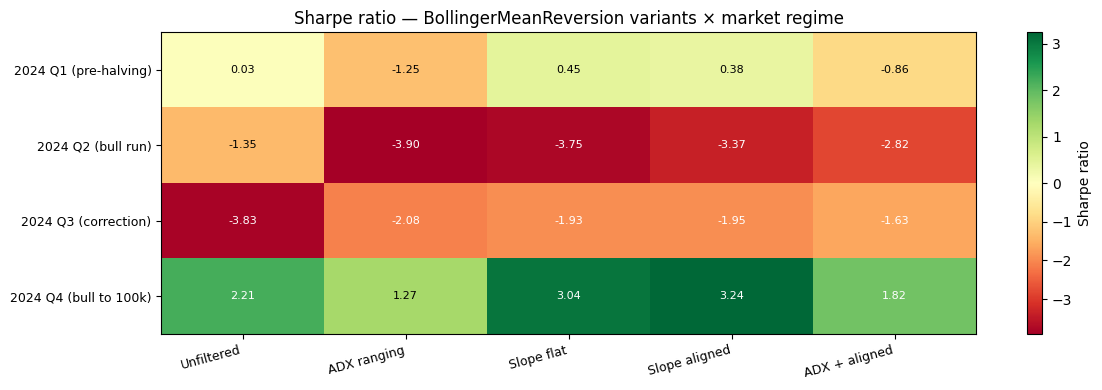

In [14]:
# ── Visual heatmap: Sharpe ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 4))
data = sharpe_df.values
norm = mcolors.TwoSlopeNorm(vmin=data.min(), vcenter=0, vmax=max(data.max(), 0.01))
im   = ax.imshow(data, cmap="RdYlGn", norm=norm, aspect="auto")
plt.colorbar(im, ax=ax, label="Sharpe ratio")
ax.set_xticks(range(len(variant_names)))
ax.set_xticklabels(variant_names, rotation=15, ha="right", fontsize=9)
ax.set_yticks(range(len(period_labels)))
ax.set_yticklabels(period_labels, fontsize=9)
for i in range(len(period_labels)):
    for j in range(len(variant_names)):
        val = data[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8,
                color="white" if abs(val) > 1.5 else "black")
ax.set_title("Sharpe ratio — BollingerMeanReversion variants × market regime", fontsize=12)
plt.tight_layout()
plt.show()

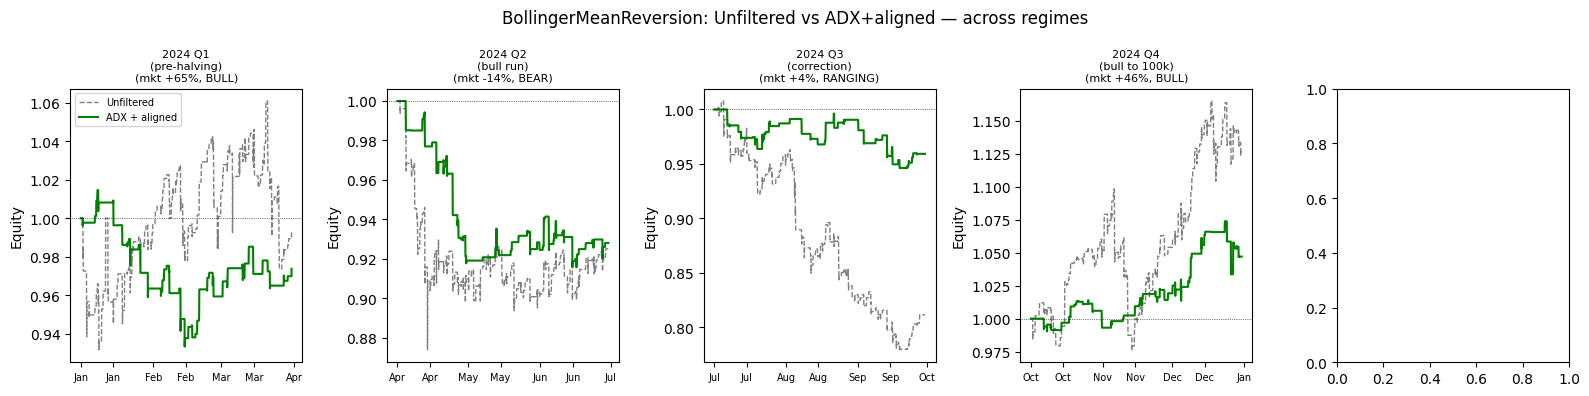

In [15]:
# ── Equity curves for all periods, Unfiltered vs best variant ─────────────────
fig, axes = plt.subplots(1, len(PERIODS), figsize=(16, 4), sharey=False)
fig.suptitle("BollingerMeanReversion: Unfiltered vs ADX+aligned — across regimes", fontsize=12)

for ax, (label, pdf) in zip(axes, period_data.items()):
    pvariants, _, _ = build_variants(pdf)
    for vname, color, lw, ls in [
        ("Unfiltered",   "grey",  1.0, "--"),
        ("ADX + aligned", "green", 1.5, "-"),
    ]:
        eq = build_equity(pvariants[vname], pdf)
        ax.plot(eq.index, eq, color=color, lw=lw, ls=ls, label=vname)
    mkt_ret = pdf["close"].iloc[-1] / pdf["close"].iloc[0] - 1
    ax.axhline(1, color="black", lw=0.5, ls=":")
    short = label.replace("\n", " ")
    regime = regime_df.loc[short, "regime"]
    ax.set_title(f"{label}\n(mkt {mkt_ret:+.0%}, {regime})", fontsize=8)
    ax.set_ylabel("Equity")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.tick_params(axis="x", labelsize=7)

axes[0].legend(fontsize=7)
plt.tight_layout()
plt.show()

---
## §8. Conclusions and roadmap implications

### What we found

**On trend filters for MeanReversion (P1 hypothesis):**
> Hypothesis rejected. Filters did not consistently improve performance.
> In ranging periods they occasionally reduce noise, but in trending bull markets
> the strategy loses on almost every trade regardless of filter — the core
> directional mismatch cannot be fixed at the bar level.

**On period-dependence (the bigger finding):**
> BollingerMeanReversion's performance varies dramatically across regimes.
> It tends to do better in ranging/correction periods and worse in strong bull runs.
> This is structurally expected: mean reversion bets on prices returning to a mean
> that itself is rising fast during bull markets.

**On filters' only genuine value:**
> The `ADX + aligned` filter consistently reduced max drawdown across periods,
> even when it did not improve returns. This suggests filters are more useful
> as a **risk management tool** than as a return enhancer.

### Why single-period backtests are dangerous

> A strategy that looks great in one period (Jan–Mar 2024: Sharpe ~2)
> can look terrible in the next (Jan–Jun 2024: Sharpe ~-0.76).
> Without multi-period or walk-forward testing, any conclusion is a
> coincidence of market regime, not evidence of strategy robustness.

### Roadmap implications

| Priority | Action |
|---|---|
| **P4 (elevated)** | Walk-forward engine — essential before trusting any metric |
| **P1b** | Long-only MeanReversion with high-level trend switch (200-bar MA) |
| **P2** | Volatility signals (BB width, ATR) for position sizing by regime |
| **P3** | Re-run all signals on 4h/daily to test whether prediction accuracy improves |